In [1]:
from mermin_benchmarking import *

In [2]:
directory = './data/'  
data = load_files(directory)

# To access ibm_sherbrooke_static, 3q data:
print(data['ibm_sherbrooke']['static']['3q'])

# To access ibm_kyiv_static, 5q data:
print(data['ibm_kyiv']['static']['5q'])


[3.80078125, 3.62890625, 3.748046875]
[14.2890625, 14.390625, 13.9765625]


In [3]:
from collections import defaultdict

def defaultdict2dict(d):
    if isinstance(d, defaultdict):
        d = {j: defaultdict2dict(k) for j, k in d.items()}
    return d

data = defaultdict2dict(data)
data

{'ibm_brisbane': {'static_sym': {'9q': [171.349609375,
    157.728515625,
    156.9453125,
    171.349609375,
    173.6953125],
   '7q': [50.529296875, 50.271484375, 50.330078125],
   '4q': [6.78125],
   '12q': [877.78125, 852.734375, 752.5546875],
   '15q': [4994.41796875, 6267.490234375, 6509.603515625]},
  'static': {'3q': [3.66796875, 3.486328125, 3.6953125],
   '5q': [10.994140625, 11.748046875, 11.853515625, 12.341796875],
   '4q': [6.96484375, 6.875, 6.90234375]},
  'dynamic': {'5q': [9.53125, 8.5625, 9.125],
   '3q': [1.913818359375, 1.3359375, 1.3515625, 1.1953125],
   '4q': [4.953125, 4.75, 4.953125]}},
 'ibm_kyiv': {'static_sym': {'9q': [175.60546875, 173.046875, 176.4921875],
   '7q': [40.05078125, 42.328125, 43.439453125],
   '12q': [1208.359375, 1123.875, 1207.796875],
   '15q': [5860.19921875, 5795.41796875, 6669.4765625]},
  'dynamic': {'3q': [0.6015625, 0.953125, 0.7421875, 2.171875, 1.3203125],
   '5q': [9.28125, 8.40625, 9.0],
   '4q': [2.578125, 2.78125, 2.296875, 3

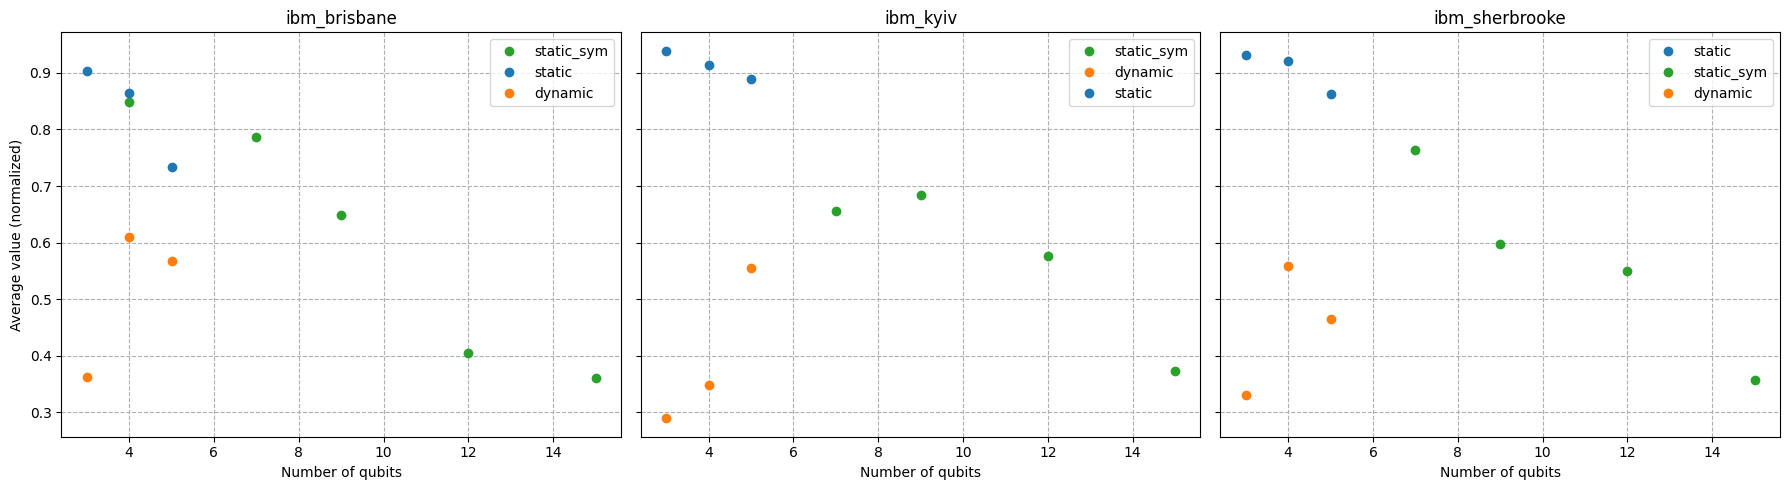

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

colors = {
    'static': 'tab:blue',
    'static_sym': 'tab:green',
    'dynamic': 'tab:orange'
}


for ax, (backend, backend_data) in zip(axes, data.items()):
    for experiment_type, qubit_data in backend_data.items():
        qubits = []
        averages = []

        for num_qubits, values in qubit_data.items():
            qubit_num = int(num_qubits.replace('q', ''))
            qubits.append(qubit_num)
            averages.append(sum(values) / len(values) / 2**(qubit_num - 1))

        if qubits:
            qubits, averages = zip(*sorted(zip(qubits, averages)))
            ax.plot(qubits, averages, 'o', label=f"{experiment_type}", color=colors.get(experiment_type, 'black'))

    ax.set_title(backend)
    ax.set_xlabel('Number of qubits')
    ax.grid(True, ls='--')
    ax.legend()

axes[0].set_ylabel('Average value (normalized)')
plt.tight_layout()
plt.show()


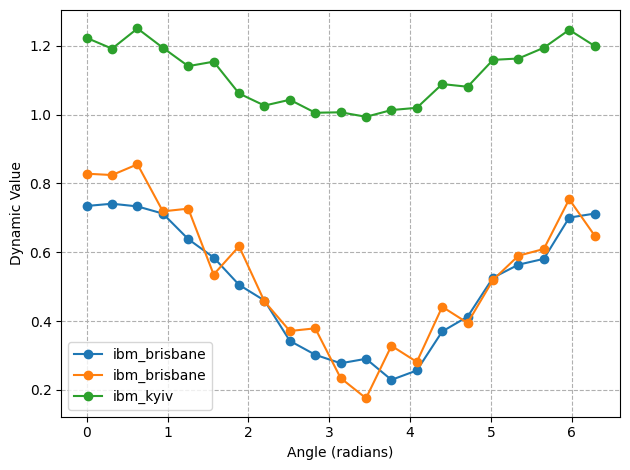

In [5]:
import json
import numpy as np
from qiskit_ibm_runtime import RuntimeEncoder, RuntimeDecoder, QiskitRuntimeService

file_paths = ["./data/ibm_brisbane-dynamic_param-2q-20250412221453.json",
             "./data/ibm_brisbane-dynamic_param-2q-20250412213722.json",
              "./data/ibm_kyiv-dynamic_param-2q-20250412223943.json"
             ]
angles = np.linspace(0, 2*np.pi, 21)

for file_path in file_paths:
    with open(file_path, "r") as file:
        result = json.load(file, cls=RuntimeDecoder)

    param_values = [counts2dynamicvalue([res]) for res in result]

    label = file_path.split("/")[-1].split("-")[0]

    plt.plot(angles, param_values, 'o-', label=label)

plt.xlabel("Angle (radians)")
plt.ylabel("Dynamic Value")
plt.legend()
plt.grid(True, ls='--')
plt.tight_layout()
plt.show()